# Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/DAT255_Semesterproject/RNN-HAR-2D-Pose-database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32

In [ ]:
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)

    X_ = np.array(np.split(X_,blocks))

    return X_

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

# Preprocessing

The dataset has keypoint detections from the OpenPose-model developed by Carnegie Mellon University. Most keypoint detection models adheres to the standard 17 keypoints in the COCO-dataset. Ulike other keypoint detection models, this model has a 18th keypoint added (the neck). We want our model to be able to use other keypoint detection models aswell and therefore we remove the 18th keypoint.

In [ ]:
filtered_X_train = np.empty((X_train.shape[0], X_train.shape[1], X_train.shape[2] - 2), dtype=X_train.dtype)

for i, video in enumerate(X_train):
    for j, frame in enumerate(video):
        filtered_X_train[i, j] = np.delete(frame, [2, 3])

X_train = filtered_X_train

filtered_X_test = np.empty((X_test.shape[0], X_test.shape[1], X_test.shape[2] - 2), dtype=X_test.dtype)

for i, video in enumerate(X_test):
    for j, frame in enumerate(video):
        filtered_X_test[i, j] = np.delete(frame, [2, 3])

X_test = filtered_X_test

The raw data in the dataset is not normalized. For example a keypoint can be 317.235. In order to make our models better at generalizing our keypoints need to be normalized before training and predicting.
A normalized keypoint should be in the range [0.0 - 1.0]. All videos in the dataset have the dimension 640 x 480. https://ieeexplore.ieee.org/document/6474999

In [ ]:
def normalize_keypoint_data(data, image_width, image_height):
    normalized_data = np.ndarray(shape=data.shape, dtype=np.float32)

    for i, video in enumerate(data):
        for j, frame in enumerate(video):
            for k, keypoint in enumerate(frame):
                normalized_data[i, j, k] = keypoint / (image_width if k % 2 == 0 else image_height)

    return normalized_data


# Resolution 640x480
X_train = normalize_keypoint_data(X_train, 640, 480)
X_test = normalize_keypoint_data(X_test, 640, 480)

# Data augmentation

We view the distribution of the labels. How many of each label do we have in the training dataset?

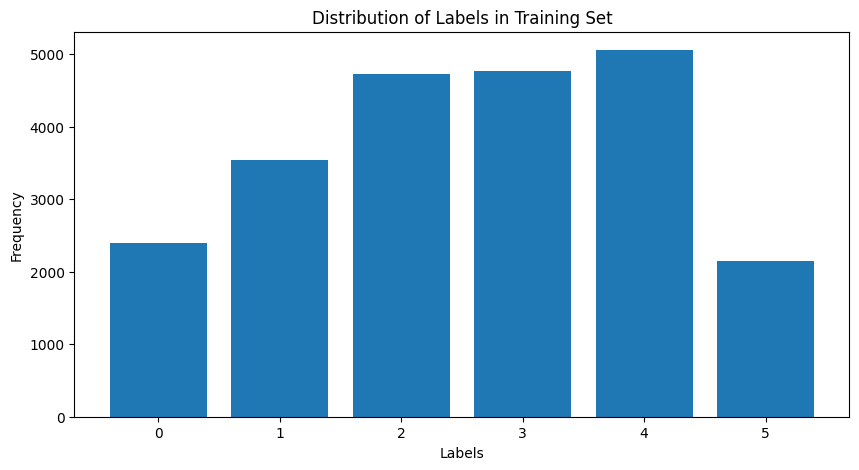

In [ ]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, label_counts)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.xticks(unique_labels)
plt.show()

We can see that label 0 and 5 are a bit underrepresented

In [ ]:
def flip_video_horizontal(video):
  video = np.copy(video)
  for frame in range(video.shape[0]):
    for keypoint in range(video.shape[1]):
      if video[frame][keypoint] == 0.0:
        continue
      if keypoint % 2 == 0:
        video[frame][keypoint] = 1 - video[frame][keypoint]

  return video

def flip_video_vertical(video):
  video = np.copy(video)
  for frame in range(video.shape[0]):
    for keypoint in range(video.shape[1]):
      if video[frame][keypoint] == 0.0:
        continue
      if keypoint % 2 == 1:
        video[frame][keypoint] = 1 - video[frame][keypoint]

  return video

In [ ]:
X_train_augmented = []
y_train_augmented = []

for i, video in enumerate(X_train):
  horizontal_flipped_video = flip_video_horizontal(video)
  vertical_flipped_video = flip_video_vertical(video)

  X_train_augmented.append(horizontal_flipped_video)
  y_train_augmented.append(y_train[i])

  X_train_augmented.append(vertical_flipped_video)
  y_train_augmented.append(y_train[i])

  if (y_train[i] == 5 or y_train[i] == 0): # For
    horizontal_vertical_flipped_video = flip_video_vertical(horizontal_flipped_video)
    X_train_augmented.append(horizontal_vertical_flipped_video)
    y_train_augmented.append(y_train[i])
    X_train_augmented.append(X_train[i]) # Duplicate
    y_train_augmented.append(y_train[i])


X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

X_train = np.concatenate((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

Notice that if the label is 0 or 5, we add more data augmentation in addition to duplicating the data. We do this to get a more balanced dataset as we display in the cell below after augmenting.

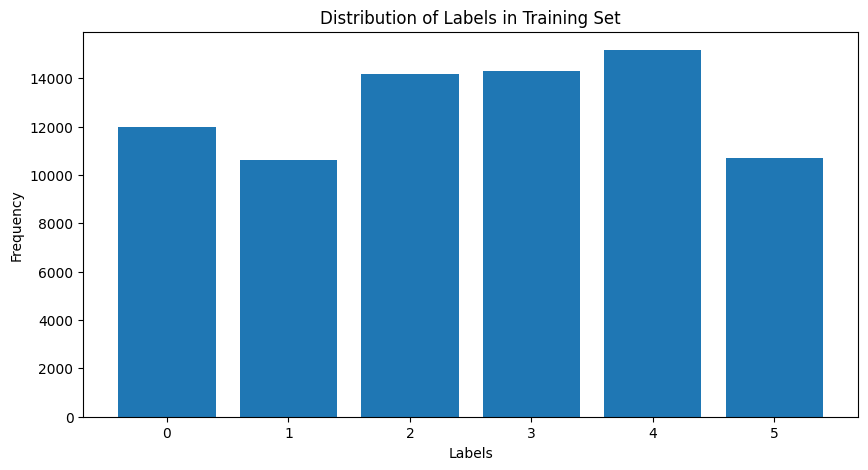

In [ ]:
unique_labels, label_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique_labels, label_counts)
plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.title("Distribution of Labels in Training Set")
plt.xticks(unique_labels)
plt.show()

Much better!

In [ ]:
X_train, y_train = shuffle(X_train, y_train)

# Save new datasets to Google Drive

In [ ]:
np.save("/content/drive/MyDrive/DAT255_Semesterproject/processed_data/X_train.npy", X_train)
np.save("/content/drive/MyDrive/DAT255_Semesterproject/processed_data/X_test.npy", X_test)
np.save("/content/drive/MyDrive/DAT255_Semesterproject/processed_data/y_train.npy", y_train)
np.save("/content/drive/MyDrive/DAT255_Semesterproject/processed_data/y_test.npy", y_test)
